In [159]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision.transforms as T
from torchvision.io import read_image
import torchvision
import math

device = 'cuda' if torch.cuda.is_available() else 'cpu'


plt.rcParams["savefig.bbox"] = 'tight'
torch.manual_seed(1)


def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = T.ToPILImage()(img.to('cpu'))
        axs[0, i].imshow(np.asarray(img), cmap='gray')
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

def mask_show(img, mask):
    fix, axs = plt.subplots()
    im = T.ToPILImage()(img.to('cpu'))
    axs.imshow(np.asarray(im), cmap='gray')
    axs.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    axs.imshow(np.asarray(mask), cmap='jet', alpha=0.5)

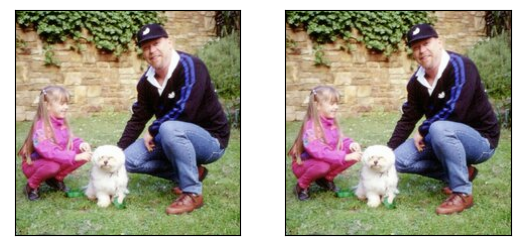

In [160]:
cat = read_image(str(Path('assets') / 'kid_dog_adult.jpg'))
cat_resize = read_image(str(Path('assets') / 'kid_dog_adult.jpg'))
show([cat, cat_resize])

In [161]:
import torch.nn as nn
from torchvision.models import vgg16, VGG16_Weights

class Predictor(nn.Module):

    def __init__(self):
        super().__init__()
        weights = VGG16_Weights.DEFAULT
        self.vgg16 = vgg16(weights=weights, progress=False).eval()
        self.transforms = weights.transforms()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            x = self.transforms(x)
            y_pred = self.vgg16(x)
            return y_pred

In [162]:
def show_prediction(pred):
    import json
    with open(Path('assets') / 'imagenet_class_index.json') as labels_file:
        labels = json.load(labels_file)
    print(f"Prediction: {labels[str(torch.argmax(pred).item())]}\nConfidence:{pred[0, torch.argmax(pred).item()]}")

In [163]:
predictor = Predictor().to(device)
batch = torch.stack([cat]).to(device)
res = predictor(batch)

show_prediction(res)

Prediction: ['n02105641', 'Old_English_sheepdog']
Confidence:13.583841323852539


In [164]:
class Predictor(nn.Module):

    def __init__(self):
        super().__init__()
        weights = VGG16_Weights.DEFAULT
        self.vgg16 = vgg16(weights=weights, progress=False).eval()
        self.transforms = weights.transforms()

    def forward(self, x: torch.Tensor, noise:torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            x = self.transforms(x)
            x_noise = x * noise
            y_pred = self.vgg16(x_noise)
            return y_pred

In [165]:
import cv2
import skimage.exposure
from numpy.random import default_rng


def generate_rmaps(n):
    r_maps = []
    r_maps.append(torch.ones([224,224]))
    for i in range(n-1):
        # define random seed to change the pattern
        rng = default_rng()
        # define image size
        width=224
        height=224
        # create random noise image
        noise = rng.integers(0, 255, (height,width), np.uint8, True)
        # blur the noise image to control the size
        blur = cv2.GaussianBlur(noise, (0,0), sigmaX=15, sigmaY=15, borderType = cv2.BORDER_DEFAULT)
        # stretch the blurred image to full dynamic range
        stretch = skimage.exposure.rescale_intensity(blur, in_range='image', out_range=(0,255)).astype(np.uint8)
        # threshold stretched image to control the size
        thresh = cv2.threshold(stretch, 175, 255, cv2.THRESH_BINARY)[1]
        # apply morphology open and close to smooth out shapes
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))
        result = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
        result = cv2.morphologyEx(result, cv2.MORPH_CLOSE, kernel)

        r_maps.append(torch.from_numpy((255-result)/255).long())
    return r_maps

#def generate_rmaps(n, p=0.49):
#    r_maps = []

#    r_maps.append(torch.ones([224,224]))
    
#    for i in range(n-1):
#        r_maps.append(torch.round(torch.rand([224,224])+p))
    
#    return r_maps

In [166]:
r_maps = generate_rmaps(10000)
for i in range(len(r_maps)):
    r_maps[i] = r_maps[i].to(device)

outputs = []

for noise in r_maps:
    predictor = Predictor().to(device)
    batch = torch.stack([cat_resize]).to(device)
    noise = noise.to(device)
    res = predictor(batch, noise)
    outputs.append(res)

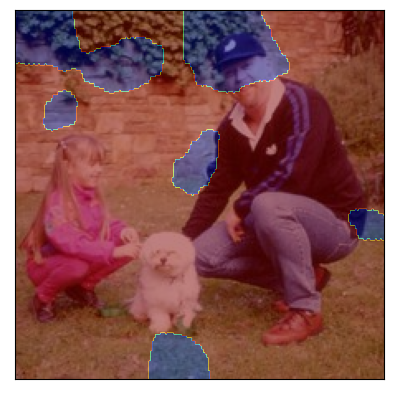

In [167]:
mask_show(cat_resize.cpu(), r_maps[99].cpu())

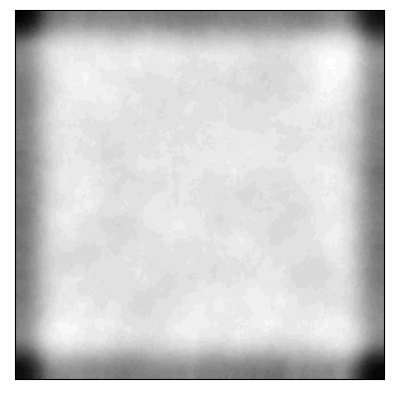

In [179]:
# Mean map
mean_map = torch.zeros([224,224]).to(device)
for i in r_maps:
    mean_map += i / len(r_maps)

show([mean_map])

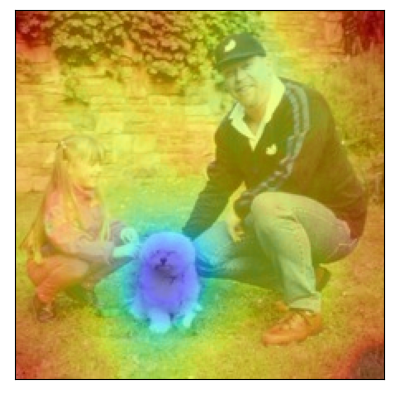

In [186]:
map = torch.zeros([224,224]).to(device)

# Distance from output vector

for i in range(len(r_maps)):
    map += (r_maps[i]-mean_map)*torch.sqrt(torch.sum(torch.square(outputs[i]-outputs[0])))/len(r_maps)

mask_show(cat_resize, map.cpu())

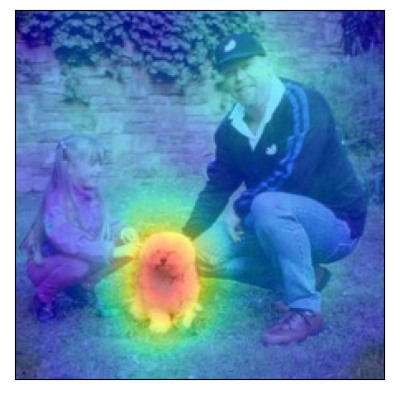

In [187]:
map = torch.zeros([224,224]).to(device)

# Distance from rigth label

for i in range(len(r_maps)):
    map += (r_maps[i]-mean_map)*(outputs[i][0, torch.argmax(outputs[0]).item()]-outputs[0][0, torch.argmax(outputs[0]).item()])/len(r_maps)

mask_show(cat_resize, map.cpu())

In [188]:
# Distance from all labels
label_maps = []

for rl_map in range(outputs[0].shape[1]):
    map = torch.zeros([224,224]).to(device)
    for i in range(len(r_maps)):
        map += (r_maps[i]-mean_map)*(outputs[i][0, rl_map]-outputs[0][0, rl_map])/len(r_maps)
    label_maps.append(map)

In [189]:
# PCA of all those maps
X = torch.empty(len(label_maps),224*224)
for i in range(len(label_maps)):
    X[i] = label_maps[i].flatten()

# Calculate the average number
#X_average=X.mean(dim=0)

# Standardize the data matrix
for i in range(len(label_maps)):
    X[i]-=X[i].mean()
    X[i]=torch.div(X[i], math.sqrt(224*224))
X=X.t()

# Calculate the SVD of this data
U, S, V = torch.linalg.svd(X)

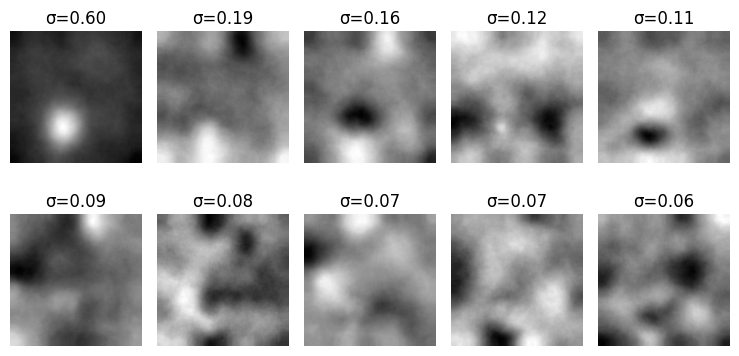

In [190]:
# Lets vizualize what these subspaces looks like
fig, axes = plt.subplots(2, 5, figsize=(1.5*5,2*2))
for i in range(10):
    ax = axes[i//5, i%5]
    ax.imshow(torch.reshape(U[:,i], (224,224)), cmap='gray')
    ax.set_title(f'σ={S[i]:.2f}')
    ax.axis('off')

plt.tight_layout()
plt.show()

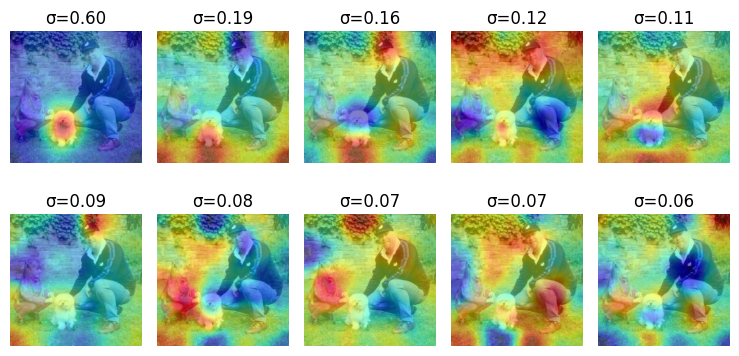

In [191]:
# Lets vizualize what these subspaces looks like
fig, axes = plt.subplots(2, 5, figsize=(1.5*5,2*2))
for i in range(10):
    ax = axes[i//5, i%5]
    im = T.ToPILImage()(cat_resize.to('cpu'))
    ax.imshow(np.asarray(im), cmap='gray')
    ax.imshow(torch.reshape(U[:,i], (224,224)), cmap='jet', alpha=0.5)
    ax.set_title(f'σ={S[i]:.2f}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [192]:
# save session
import dill
dill.dump_session('notebook_env_kid.db')

In [175]:
#import dill
#dill.load_session('notebook_env_kid.db')